In [1]:
import datasets
from transformers import AutoImageProcessor, AutoModel, AutoTokenizer
from huggingface_hub import login

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import math
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score

from tqdm import tqdm
import matplotlib.pyplot as plt
import os

from dataclasses import dataclass

/home/saimadhavang/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
dataset = datasets.load_dataset("Gapes21/vqa2", split = "train")

In [4]:
labelEncoder = LabelEncoder()
labelEncoder.fit(dataset['answer'])

LabelEncoder()

In [5]:
labelMap = {}
for i, label in enumerate(labelEncoder.classes_):
    labelMap[label] = i
class_counts = [0 for i in range(len(labelMap))]
for label in tqdm(dataset["answer"]):
    labelid = labelMap[label]
    class_counts[labelid] += 1
total_samples = sum(class_counts)
class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]

100%|██████████| 109485/109485 [00:00<00:00, 1788555.35it/s]


In [6]:
BERT = "smallbenchnlp/roberta-small"
VIT = 'facebook/dinov2-small'

In [7]:
processor = AutoImageProcessor.from_pretrained(VIT)
tokenizer = AutoTokenizer.from_pretrained(BERT)

/home/saimadhavang/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
class SastaLoader:
    def __init__(self, dataset, batch_size, collator_fn, train_max = 100000, mode = "train"):
        self.dataset = dataset.shuffle()
        self.collator_fn = collator_fn
        self.len = len(self.dataset)
        self.batch_size = batch_size
        if mode == "train":
            self.index = 0
        else :
            self.index = train_max
        self.train_max = train_max
        self.mode = mode

    def hasNext(self):
        if self.mode == "train":
            return self.index + self.batch_size <= self.train_max
        else :
            return self.index + self.batch.size <= self.len
    
    def reset(self):
        if self.mode == "train":
            self.index = 0
        else:
            self.index = self.train_max
        
    def __iter__(self):
        return self

    def __next__(self):
        if self.mode == "train":
            if self.index >= self.train_max:
                raise StopIteration
        else :
            if self.index >= self.len:
                raise StopIteration
                
        batch = self.dataset[self.index: self.index + self.batch_size]
        batch = self.collator_fn(batch)
        self.index += self.batch_size
        return batch
    
    def __len__(self):
        if self.mode == "train":
            return self.train_max
        return self.len - self.train_max
    
    def train(self):
        self.mode = "train"
        
    def validate(self):
        self.mode = "validation"

In [10]:
def sasta_collator(batch):
    # process images
    images = processor(images = batch['image'], return_tensors="pt")['pixel_values']

    # preprocess questions
    questions = tokenizer(
            text=batch['question'],
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_attention_mask=True,
        )

    # process labels
    labels = torch.Tensor(labelEncoder.transform(batch['answer']))
    return (images, questions, labels)


In [11]:
class DinoBertSmall(nn.Module):
    def __init__(
        self,
        num_labels,
        intermediate_dim,
        pretrained_text_name,
        pretrained_image_name,
        classifier_dim = 9024,
    ):
        super(DinoBertSmall, self).__init__()
        
        self.num_labels = num_labels
        self.intermediate_dim = intermediate_dim
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name
        self.classifier_dim = classifier_dim
        
        # Text and image encoders
        
        self.text_encoder = AutoModel.from_pretrained(self.pretrained_text_name)
        self.image_encoder = AutoModel.from_pretrained(self.pretrained_image_name)

        for param in self.text_encoder.parameters():
            param.requires_grad = False

        for param in self.image_encoder.parameters():
            param.requires_grad = False

#         assert(self.text_encoder.config.hidden_size == self.image_encoder.config.hidden_size)

        self.embedd_dim_text = self.text_encoder.config.hidden_size
        self.embedd_dim_img = self.image_encoder.config.hidden_size

        print(self.embedd_dim_text, self.embedd_dim_img)

        # Classifier
        self.initdim = self.embedd_dim_img + self.embedd_dim_text
        self.classifier = nn.Linear(self.initdim, self.num_labels)


    def forward(
        self,
        input_ids,
        pixel_values,
        attention_mask
    ):
        # Encode text with masking
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        
        # Encode images
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
        )
        
        text = encoded_text.last_hidden_state
        img = encoded_image.last_hidden_state
        
        conatt = torch.cat((text[:, 0, :], img[:, 0, :]), dim = 1)
        conatt = conatt.view(conatt.shape[0], -1)
        
        # Make predictions
        logits = self.classifier(conatt)
        return logits

In [12]:
def save_model(model, name):
    torch.save(model.state_dict(), name)

def initVQA():
    model = DinoBertSmall(len(labelEncoder.classes_), 512, BERT, VIT).to(device)
    return model

def load_model(name, backup = initVQA, frommem = True):
    model = backup()
    if frommem == False:
        print("Initializing from scratch.")
        return model
    try : 
        model.load_state_dict(torch.load(f"/kaggle/working/{name}"))
        print("Loaded model successfully.")
    except:
        print("Couldn't find model. Initializing from scratch.")
    return model

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

### Testing the model and tweaking it

In [13]:
# collator_fn = sasta_collator
# loader = SastaLoader(dataset, 1, sasta_collator)
# model = load_model("vqa_dr.pth", frommem = False)

# ids, pxlvalues, masks, labels = None, None, None, None
# for batchid, batch in enumerate(loader):
#     ids = batch[1]['input_ids'].to(device)
#     pxlvalues = batch[0].to(device)
#     masks = batch[1]['attention_mask'].to(device)
#     labels = batch[2].to(device)
#     break
# len(ids), len(pxlvalues), len(masks), len(labels)

In [14]:
# outputs = model(ids, pxlvalues, masks)

## Training

#### Model, optimizer and loss

In [26]:
model = initVQA()

/home/saimadhavang/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at smallbenchnlp/roberta-small and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


256 384


In [27]:
model.load_state_dict(torch.load("./vqa_expt_3_8.pth"))
print_trainable_parameters(model)

trainable params: 5907456 || all params: 50408320 || trainable%: 11.72


In [32]:
for param in model.text_encoder.parameters():
    param.requires_grad = True

for param in model.image_encoder.parameters():
    param.requires_grad = True

In [33]:
print_trainable_parameters(model.text_encoder)
print_trainable_parameters(model.image_encoder)
print_trainable_parameters(model.classifier)

trainable params: 22444288 || all params: 22444288 || trainable%: 100.00
trainable params: 22056576 || all params: 22056576 || trainable%: 100.00
trainable params: 5907456 || all params: 5907456 || trainable%: 100.00


In [34]:
from peft import LoraConfig, get_peft_model
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
)
lora_te = get_peft_model(model.text_encoder, config)
lora_ie = get_peft_model(model.image_encoder, config)
print_trainable_parameters(model)

trainable params: 6398976 || all params: 50899840 || trainable%: 12.57


#### Hyperparams

In [35]:
collator_fn = sasta_collator
loader = SastaLoader(dataset, 64, sasta_collator)
num_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss(weight = torch.tensor(class_weights, dtype=torch.float).to(device))
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [36]:
def train(model, optimizer, criterion, scheduler, loader, num_epochs, device):
    loss_plot, accuracy_plot = [], []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total_samples = 0
        with tqdm(total=len(loader), desc="Processing batches", dynamic_ncols=True) as pbar:
            for batchidx, batch in enumerate(loader):
                ids = batch[1]['input_ids'].to(device)
                pxlvalues = batch[0].to(device)
                masks = batch[1]['attention_mask'].to(device)
                labels = batch[2].to(device)

                optimizer.zero_grad()
                outputs = model(ids, pxlvalues, masks)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * loader.batch_size
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)
                pbar.update(loader.batch_size)
                if batchidx % 16000 == 1:
                    save_model(model, 'vqa_dr.pth')
                
        epoch_loss = total_loss / total_samples
        accuracy = correct / total_samples
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")
        accuracy_plot.append(accuracy * 100)
        loss_plot.append(epoch_loss)
        save_model(model, f"vqa_expt_4_{epoch}.pth")
        scheduler.step()
        loader.reset()
    plt.plot(accuracy_plot)
    plt.plot(loss_plot)

Processing batches: 100032it [24:16, 68.67it/s]                           


Epoch 1/10, Loss: 5.9531, Accuracy: 0.0980


Processing batches: 100032it [24:29, 68.08it/s]                           


Epoch 2/10, Loss: 1.7918, Accuracy: 0.1796


Processing batches: 100032it [24:21, 68.43it/s]                           


Epoch 3/10, Loss: 0.9172, Accuracy: 0.2621


Processing batches: 100032it [24:01, 69.39it/s]                           


Epoch 4/10, Loss: 0.5238, Accuracy: 0.3004


Processing batches: 100032it [23:59, 69.50it/s]                           


Epoch 5/10, Loss: 0.3661, Accuracy: 0.3196


Processing batches: 100032it [23:59, 69.50it/s]                           


Epoch 6/10, Loss: 0.3403, Accuracy: 0.3286


Processing batches: 100032it [24:14, 68.78it/s]                           


Epoch 7/10, Loss: 0.3213, Accuracy: 0.3327


Processing batches: 100032it [23:59, 69.50it/s]                           


Epoch 8/10, Loss: 0.3202, Accuracy: 0.3322


Processing batches: 100032it [23:55, 69.70it/s]                           


Epoch 9/10, Loss: 0.3190, Accuracy: 0.3337


Processing batches: 100032it [23:56, 69.65it/s]                           


Epoch 10/10, Loss: 0.3168, Accuracy: 0.3331


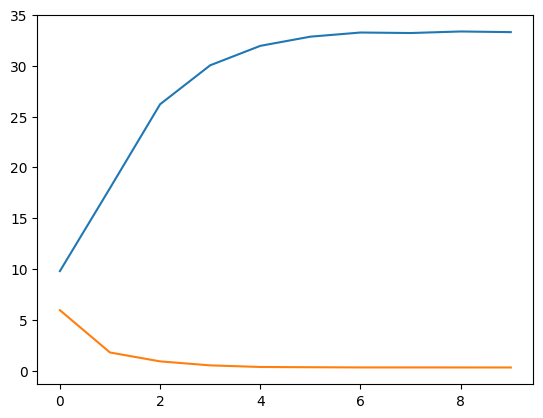

In [37]:
train(model, optimizer, criterion, scheduler, loader, num_epochs, device)

In [38]:
validation_loader = SastaLoader(dataset, 16, sasta_collator, mode = "validation")

In [39]:
def evaluate_model(model, loader, device):
    y_true, y_pred = [], []
    model.eval()
#     loader.reset()
    with tqdm(total=len(loader), desc="Processing batches", dynamic_ncols=True) as pbar:
        for batchidx, batch in enumerate(loader):
            ids = batch[1]['input_ids'].to(device)
            pxlvalues = batch[0].to(device)
            masks = batch[1]['attention_mask'].to(device)
            labels = batch[2].to("cpu")
            outputs = model(ids, pxlvalues, masks)
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.to("cpu")
            y_true.extend(labels)
            y_pred.extend(predicted)
            pbar.update(loader.batch_size)
    f1 = f1_score(y_true, y_pred, average = "weighted")
    accuracy = accuracy_score(y_true, y_pred)
    print(f"F1-score: {f1 : 0.2f}")
    print(f"Accuracy: {accuracy * 100 : 0.2f}%")
    return y_pred

In [40]:
y_pred = evaluate_model(model, validation_loader, device)

Processing batches: 9488it [02:06, 74.94it/s]                          


F1-score:  0.37
Accuracy:  35.62%


In [41]:
label_dict = dict()
for label in y_pred:
    if label.item() in label_dict:
        label_dict[label.item()] += 1
    else:
        label_dict[label.item()] = 1
    
for label in label_dict.keys():
    print(f"{labelEncoder.inverse_transform([label])} : {label_dict[label]}")

['black'] : 38
['2:27'] : 2
['flannel'] : 3
['boats'] : 7
['easy access'] : 1
['20'] : 29
['1'] : 117
['tm'] : 1
['cookies'] : 1
['up'] : 8
['jeans'] : 4
['always'] : 1
['bird'] : 4
['sunglasses'] : 5
['pharos'] : 2
['stop'] : 9
['6'] : 78
['with her arms'] : 1
['suitcases'] : 2
['no'] : 327
['country'] : 5
['8'] : 49
['lamp'] : 8
['me'] : 2
['peach'] : 2
['yes'] : 377
['2'] : 69
['park'] : 6
['white'] : 41
['zoo'] : 7
['gray'] : 38
['standing'] : 7
['coleslaw'] : 4
['many'] : 22
['indoors'] : 6
['playing frisbee'] : 5
['oranges'] : 4
['red'] : 67
['on wall'] : 3
['carpet'] : 10
['dark one'] : 1
['bowl'] : 2
['granite'] : 3
['wild'] : 16
['handrail'] : 1
['sheep wrestling'] : 1
['happy'] : 16
['winton bournemouth'] : 1
['all'] : 6
['metal'] : 10
['scissors'] : 7
['barney'] : 1
['mane'] : 4
['away'] : 8
['traffic lights'] : 1
['beans'] : 5
['table'] : 4
['half pipe'] : 1
['flowers'] : 3
['next to woman'] : 1
['bat'] : 8
['dogs pee on fire hydrants'] : 1
['gas'] : 2
['softball'] : 1
['le